<a href="https://colab.research.google.com/github/yblee110/jax-flax-book/blob/main/ch04_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jax==0.4.24
!pip install flax==0.7.5
!pip install optax==0.1.7
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: jax
    Found existing installation: jax 0.4.23
    Uninstalling jax-0.4.23:
      Successfully uninstalled jax-0.4.23
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: flax
    Found existing installation: flax 0.8.1
    Uninstalling flax-0.8.1:
      Successfully uninstalled flax-0.8.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: optax
    Found existing installation: optax 0.2.1
    Uninstalling optax-0.2.1:
      Successfully uninstalled optax-0.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta

In [2]:
import jax
import flax
import optax


print("JAX Version : {}".format(jax.__version__))
print("FLAX Version : {}".format(flax.__version__))
print("OPTAX Version : {}".format(optax.__version__))


JAX Version : 0.4.24
FLAX Version : 0.7.5
OPTAX Version : 0.1.7


In [3]:
batch_size = 2048
z_dim = 64
seed = 0

In [4]:
import jax.numpy as jnp
from datasets import load_dataset


def get_datasets():
    datasets = load_dataset("mnist")
    datasets = datasets.with_format("jax")
    datasets = {
        "train": {
            "image": (datasets["train"]["image"][...,None].astype(jnp.float32)/255 - 0.5) / 0.5,
            "label": datasets["train"]["label"],
        }
    }
    return datasets['train']


In [5]:
train_ds = get_datasets()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
from functools import partial
from typing import Any, Callable, Sequence, Tuple


from jax.nn.initializers import normal as normal_init
from flax import linen as nn
import jax.numpy as jnp


ModuleDef = Any


In [7]:
class Generator(nn.Module):
    features: int = z_dim
    dtype: type = jnp.float32


    @nn.compact
    def __call__(self, z: jnp.ndarray, train: bool = True):
        conv_transpose = partial(nn.ConvTranspose, padding='VALID',
                                kernel_init=normal_init(0.02), dtype=self.dtype)
        batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                            scale_init=normal_init(0.02), dtype=self.dtype)


        z = z.reshape((batch_size, 1, 1, z_dim))
        x = conv_transpose(self.features*4, kernel_size=[3, 3], strides=[2, 2])(z)
        x = batch_norm()(x)
        x = nn.relu(x)
        x = conv_transpose(self.features*4, kernel_size=[4, 4], strides=[1, 1])(x)
        x = batch_norm()(x)
        x = nn.relu(x)
        x = conv_transpose(self.features*2, kernel_size=[3, 3], strides=[2, 2])(x)
        x = batch_norm()(x)
        x = nn.relu(x)
        x = conv_transpose(1, [4, 4], [2, 2])(x)
        x = jnp.tanh(x)
        return x

In [8]:
class Discriminator(nn.Module):
    features: int = z_dim
    dtype: Any = jnp.float32


    @nn.compact
    def __call__(self, x: jnp.ndarray, train: bool = True):
        conv = partial(nn.Conv, kernel_size=[4, 4], strides=[2, 2], padding='VALID',
                    kernel_init=normal_init(0.02), dtype=self.dtype)
        batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                            scale_init=normal_init(0.02), dtype=self.dtype)


        x = conv(self.features)(x)
        x = batch_norm()(x)
        x = nn.leaky_relu(x, 0.2)
        x = conv(self.features*2)(x)
        x = batch_norm()(x)
        x = nn.leaky_relu(x, 0.2)
        x = conv(1)(x)
        x = x.reshape((batch_size, -1))
        return x


In [9]:
def generator_step(generator_state, discriminator_state, key):
    input_noise = jax.random.normal(key, (batch_size, z_dim))


    def loss_fn(params):
        generated_data, mutables = generator_state.apply_fn(
            {'params': params, 'batch_stats': generator_state.batch_stats},
            input_noise, mutable=['batch_stats'])


        logits, _ = discriminator_state.apply_fn(
                {'params': discriminator_state.params,
                'batch_stats': discriminator_state.batch_stats},
                generated_data, mutable=['batch_stats'])


        loss = -jnp.mean(jnp.log(nn.sigmoid(logits)))


        return loss, mutables


    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(generator_state.params)


    generator_state = generator_state.apply_gradients(
        grads=grads, batch_stats=updates['batch_stats'])


    return generator_state, loss

In [10]:
def discriminator_step(generator_state, discriminator_state, batch, key):
    input_noise = jax.random.normal(key, (batch_size, z_dim))


    generated_data, _ = generator_state.apply_fn(
        {'params': generator_state.params, 'batch_stats': generator_state.batch_stats},
        input_noise, mutable=['batch_stats'])


    def loss_fn(params):
        logits_real, mutables = discriminator_state.apply_fn(
            {'params': params, 'batch_stats': discriminator_state.batch_stats},
            batch, mutable=['batch_stats'])


        logits_generated, mutables = discriminator_state.apply_fn(
            {'params': params, 'batch_stats': mutables['batch_stats']},
            generated_data, mutable=['batch_stats'])


        real_loss = optax.sigmoid_binary_cross_entropy(
            logits_real, jnp.ones((batch_size, 1), dtype=jnp.int32)).mean()
        generated_loss = optax.sigmoid_binary_cross_entropy(
            logits_generated, jnp.zeros((batch_size, 1), dtype=jnp.int32)).mean()


        loss = (real_loss + generated_loss) / 2


        return loss, mutables


    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(discriminator_state.params)


    discriminator_state = discriminator_state.apply_gradients(
        grads=grads, batch_stats=updates['batch_stats'])


    return discriminator_state, loss


In [11]:
from flax.training import train_state


class TrainState(train_state.TrainState):
    batch_stats: Any


def create_state(rng, model_cls, input_shape):
    model = model_cls()


    b1 = 0.5
    b2 = 0.999
    learning_rate = 0.002
    tx = optax.adam(learning_rate=learning_rate, b1=b1, b2=b2)


    variables = model.init(rng, input_shape)


    state = TrainState.create(
        apply_fn=model.apply,
        params=variables['params'],
        batch_stats=variables['batch_stats'],
        tx=tx
    )


    return state


def generate_sample(generator_state, input_noise):
    generated_data = generator_state.apply_fn(
        {'params': generator_state.params,
         'batch_stats': generator_state.batch_stats},
        input_noise, train=False, mutable=False
    )


    return generated_data


rng = jax.random.PRNGKey(0)
key_generator, key_discriminator, key = jax.random.split(rng, 3)


discriminator_state = create_state(key_discriminator, Discriminator, jnp.ones((batch_size, 28, 28, 1)))
generator_state = create_state(key_generator, Generator, jnp.ones((batch_size, z_dim)))


generator_input = jax.random.normal(key, (batch_size, z_dim))


In [12]:
from tqdm.notebook import tqdm


def train_loop(generator_state, discriminator_state, train_ds, batch_size, epoch, key):
    train_ds_size = train_ds['image'].shape[0]
    steps_per_epoch = train_ds_size // batch_size


    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))


    batch_metrics = {
        'generator_loss' : [],
        'discriminator_loss' : []
        }


    with tqdm(total=steps_per_epoch, desc="Training...",
                leave=False) as progress_bar_train:


        for perm in perms:
            # generator와 discriminator를 위한 RNG 키를 생성합니다.
            key, key_generator, key_discriminator = jax.random.split(key, 3)


            batch_data = train_ds['image'][perm, ...]


            # generator step.
            generator_state, generator_loss = generator_step(generator_state,
                discriminator_state, key_generator)


            # discriminator .
            discriminator_state, discriminator_loss = discriminator_step(
                generator_state, discriminator_state, batch_data, key_discriminator)


            batch_metrics['generator_loss'].append(generator_loss)
            batch_metrics['discriminator_loss'].append(discriminator_loss)


            progress_bar_train.update(1)


        message = f"Epoch: {epoch: <2} | "
        message += f"Generator loss: {sum(batch_metrics['generator_loss']) / len(batch_metrics['generator_loss']):.3f} | "
        message += f"Discriminator loss: {sum(batch_metrics['discriminator_loss']) / len(batch_metrics['discriminator_loss']):.3f}"


        progress_bar_train.write(message)


    return generator_state, discriminator_state


train_epoch = 100


for epoch in tqdm(range(1, train_epoch + 1), desc="Epoch...",
                  position=0, leave=True):
    generator_state, discriminator_state = train_loop(generator_state, discriminator_state, train_ds, batch_size, epoch, key)


Epoch...:   0%|          | 0/100 [00:00<?, ?it/s]

Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 1  | Generator loss: 0.806 | Discriminator loss: 0.591


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 2  | Generator loss: 1.495 | Discriminator loss: 0.538


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 3  | Generator loss: 1.846 | Discriminator loss: 0.424


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 4  | Generator loss: 1.850 | Discriminator loss: 0.496


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 5  | Generator loss: 1.916 | Discriminator loss: 0.501


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 6  | Generator loss: 1.814 | Discriminator loss: 0.591


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 7  | Generator loss: 1.818 | Discriminator loss: 0.561


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 8  | Generator loss: 1.841 | Discriminator loss: 0.584


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 9  | Generator loss: 1.807 | Discriminator loss: 0.539


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 10 | Generator loss: 1.472 | Discriminator loss: 0.565


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 11 | Generator loss: 1.626 | Discriminator loss: 0.524


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 12 | Generator loss: 1.593 | Discriminator loss: 0.489


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 13 | Generator loss: 1.623 | Discriminator loss: 0.554


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 14 | Generator loss: 1.693 | Discriminator loss: 0.490


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 15 | Generator loss: 1.556 | Discriminator loss: 0.546


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 16 | Generator loss: 1.626 | Discriminator loss: 0.531


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 17 | Generator loss: 1.508 | Discriminator loss: 0.525


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 18 | Generator loss: 1.524 | Discriminator loss: 0.520


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 19 | Generator loss: 1.441 | Discriminator loss: 0.528


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 20 | Generator loss: 1.387 | Discriminator loss: 0.634


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 21 | Generator loss: 1.343 | Discriminator loss: 0.593


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 22 | Generator loss: 1.351 | Discriminator loss: 0.590


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 23 | Generator loss: 1.291 | Discriminator loss: 0.520


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 24 | Generator loss: 1.296 | Discriminator loss: 0.565


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 25 | Generator loss: 1.191 | Discriminator loss: 0.555


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 26 | Generator loss: 1.141 | Discriminator loss: 0.642


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 27 | Generator loss: 1.208 | Discriminator loss: 0.613


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 28 | Generator loss: 1.113 | Discriminator loss: 0.587


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 29 | Generator loss: 1.077 | Discriminator loss: 0.612


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 30 | Generator loss: 1.027 | Discriminator loss: 0.595


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 31 | Generator loss: 1.000 | Discriminator loss: 0.584


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 32 | Generator loss: 1.044 | Discriminator loss: 0.727


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 33 | Generator loss: 0.945 | Discriminator loss: 0.718


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 34 | Generator loss: 1.019 | Discriminator loss: 0.646


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 35 | Generator loss: 0.961 | Discriminator loss: 0.611


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 36 | Generator loss: 0.935 | Discriminator loss: 0.596


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 37 | Generator loss: 0.936 | Discriminator loss: 0.597


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 38 | Generator loss: 0.921 | Discriminator loss: 0.627


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 39 | Generator loss: 0.956 | Discriminator loss: 0.612


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 40 | Generator loss: 0.918 | Discriminator loss: 0.608


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 41 | Generator loss: 0.940 | Discriminator loss: 0.609


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 42 | Generator loss: 0.919 | Discriminator loss: 0.645


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 43 | Generator loss: 0.939 | Discriminator loss: 0.637


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 44 | Generator loss: 0.916 | Discriminator loss: 0.605


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 45 | Generator loss: 0.945 | Discriminator loss: 0.637


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 46 | Generator loss: 0.934 | Discriminator loss: 0.640


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 47 | Generator loss: 0.925 | Discriminator loss: 0.618


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 48 | Generator loss: 0.943 | Discriminator loss: 0.631


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 49 | Generator loss: 0.932 | Discriminator loss: 0.653


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 50 | Generator loss: 0.895 | Discriminator loss: 0.624


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 51 | Generator loss: 0.884 | Discriminator loss: 0.605


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 52 | Generator loss: 0.890 | Discriminator loss: 0.618


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 53 | Generator loss: 0.879 | Discriminator loss: 0.685


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 54 | Generator loss: 0.891 | Discriminator loss: 0.648


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 55 | Generator loss: 0.875 | Discriminator loss: 0.604


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 56 | Generator loss: 0.855 | Discriminator loss: 0.657


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 57 | Generator loss: 0.874 | Discriminator loss: 0.615


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 58 | Generator loss: 0.884 | Discriminator loss: 0.650


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 59 | Generator loss: 0.922 | Discriminator loss: 0.647


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 60 | Generator loss: 0.893 | Discriminator loss: 0.623


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 61 | Generator loss: 0.868 | Discriminator loss: 0.617


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 62 | Generator loss: 0.862 | Discriminator loss: 0.644


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 63 | Generator loss: 0.830 | Discriminator loss: 0.631


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 64 | Generator loss: 0.853 | Discriminator loss: 0.633


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 65 | Generator loss: 0.849 | Discriminator loss: 0.633


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 66 | Generator loss: 0.868 | Discriminator loss: 0.686


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 67 | Generator loss: 0.894 | Discriminator loss: 0.627


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 68 | Generator loss: 0.842 | Discriminator loss: 0.634


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 69 | Generator loss: 0.820 | Discriminator loss: 0.645


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 70 | Generator loss: 0.862 | Discriminator loss: 0.642


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 71 | Generator loss: 0.837 | Discriminator loss: 0.652


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 72 | Generator loss: 0.831 | Discriminator loss: 0.632


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 73 | Generator loss: 0.830 | Discriminator loss: 0.656


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 74 | Generator loss: 0.829 | Discriminator loss: 0.697


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 75 | Generator loss: 0.909 | Discriminator loss: 0.657


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 76 | Generator loss: 0.878 | Discriminator loss: 0.637


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 77 | Generator loss: 0.891 | Discriminator loss: 0.642


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 78 | Generator loss: 0.844 | Discriminator loss: 0.642


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 79 | Generator loss: 0.815 | Discriminator loss: 0.648


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 80 | Generator loss: 0.829 | Discriminator loss: 0.630


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 81 | Generator loss: 0.849 | Discriminator loss: 0.645


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 82 | Generator loss: 0.803 | Discriminator loss: 0.637


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 83 | Generator loss: 0.846 | Discriminator loss: 0.671


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 84 | Generator loss: 0.829 | Discriminator loss: 0.638


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 85 | Generator loss: 0.784 | Discriminator loss: 0.653


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 86 | Generator loss: 0.814 | Discriminator loss: 0.644


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 87 | Generator loss: 0.830 | Discriminator loss: 0.662


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 88 | Generator loss: 0.815 | Discriminator loss: 0.673


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 89 | Generator loss: 0.844 | Discriminator loss: 0.647


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 90 | Generator loss: 0.802 | Discriminator loss: 0.644


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 91 | Generator loss: 0.779 | Discriminator loss: 0.643


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 92 | Generator loss: 0.783 | Discriminator loss: 0.651


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 93 | Generator loss: 0.787 | Discriminator loss: 0.650


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 94 | Generator loss: 0.845 | Discriminator loss: 0.660


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 95 | Generator loss: 0.774 | Discriminator loss: 0.657


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 96 | Generator loss: 0.778 | Discriminator loss: 0.644


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 97 | Generator loss: 0.794 | Discriminator loss: 0.646


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 98 | Generator loss: 0.770 | Discriminator loss: 0.650


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 99 | Generator loss: 0.828 | Discriminator loss: 0.646


Training...:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 100 | Generator loss: 0.780 | Discriminator loss: 0.671


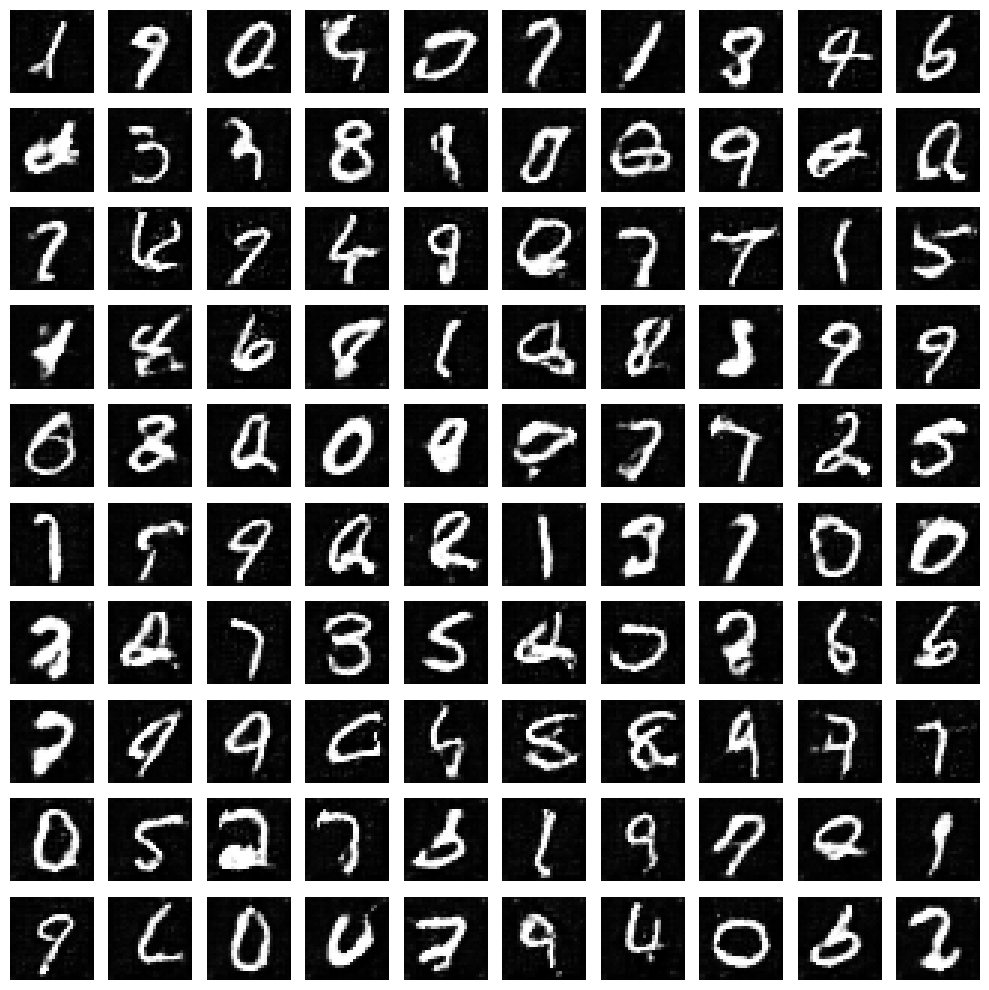

In [13]:
import matplotlib.pyplot as plt


sample = generate_sample(generator_state, generator_input)
sample = sample.reshape((-1, 28, 28))[:100]


fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for ax, image in zip(sum(axs.tolist(), []), sample):
    ax.imshow(image, cmap='gray', interpolation='nearest')
    ax.axis('off')
plt.tight_layout()
plt.show()
